#  <center>  **시계열 자료분석 HW05(final)**  </center> 

## <div style="text-align: right">  201822037 통계학과 한민주 </div> 

----

In [406]:
# packages
library(lmtest)
library(fpp2)
library(data.table)
library(fUnitRoots)
library(forecast)
library(fracdiff)
library(TTR)


Attaching package: 'TTR'


The following object is masked from 'package:fBasics':

    volatility




## 2. [sheep] 어떤 지역의 1867년부터 1939년가지 양의 개채 수 변화

In [52]:
# 데이터 확인
sheep ; print(paste0(length(sheep),"개의 데이터"))

A Time Series:
 [1] 2203 2360 2254 2165 2024 2078 2214 2292 2207 2119 2119 2137 2132 1955 1785
[16] 1747 1818 1909 1958 1892 1919 1853 1868 1991 2111 2119 1991 1859 1856 1924
[31] 1892 1916 1968 1928 1898 1850 1841 1824 1823 1843 1880 1968 2029 1996 1933
[46] 1805 1713 1726 1752 1795 1717 1648 1512 1338 1383 1344 1384 1484 1597 1686
[61] 1707 1640 1611 1632 1775 1850 1809 1653 1648 1665 1627 1791 1797

[1] "73개의 데이터"


### 2-(1) 시계열 그림

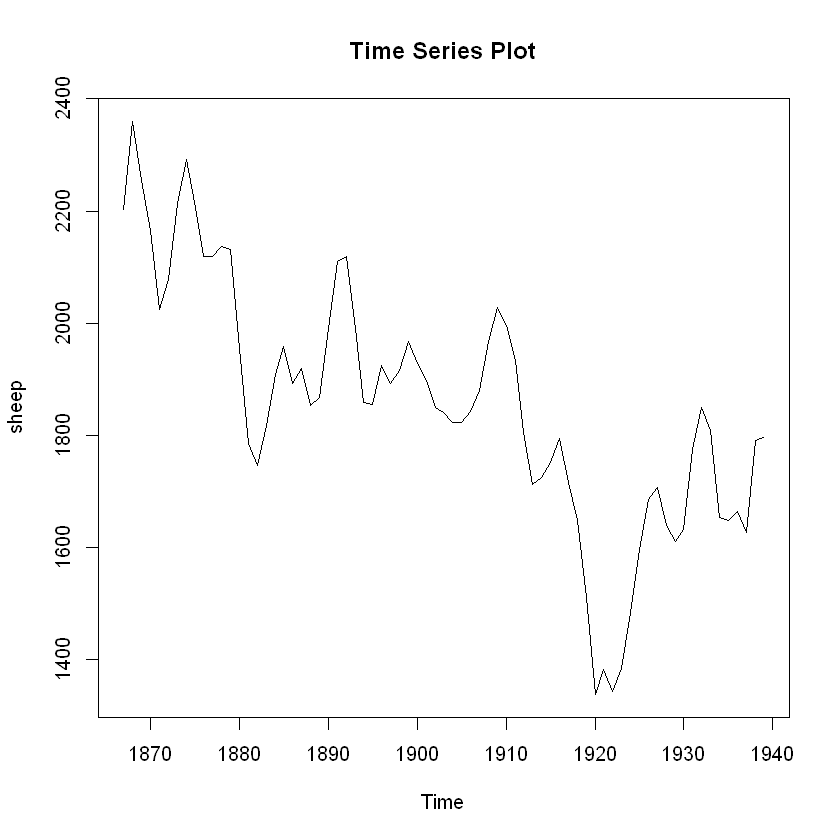

In [32]:
ts.plot(sheep , main = "Time Series Plot")

- 시간이 지남에 따라 감소하는 추세가 있어보인다.
- 이분산성과 계절성은 없어보인다.

### 2-(2) 모형 가정

<center> $Z_t = Z_{t-1} + \phi_1 (Z_{t-1} -Z_{t-2}) + \phi_2 (Z_{t-2} - Z_{t-3}) + \phi_3 (Z_{t-3} - Z_{t-4}) +\epsilon_t $ $, \epsilon_t  \sim WN(0 , \sigma^2)$</center>  

위 모형식은   

<center>  $(1-B)Z_t = \phi_1 (1-B)Z_{t-1} + \phi_2 (1-B)Z_{t-2} + \phi_3 (1-B)Z_{t-3} + \epsilon_t $   </center>  
<center>  $  (=) (1-\phi_1 B - \phi_2 B^2 -\phi_3 B^3)(1-B)Z_t = \epsilon_t$  </center>  
<center>  $ (=) \Phi(B)(1-B)Z_t = \epsilon_t$ </center>  

이므로 **ARIMA(3,1,0)** 모형이다.

### 2-(3) 가정한 모형이 적합한지 확인

In [576]:
# 1번 차분
diff_sheep = diff(sheep)

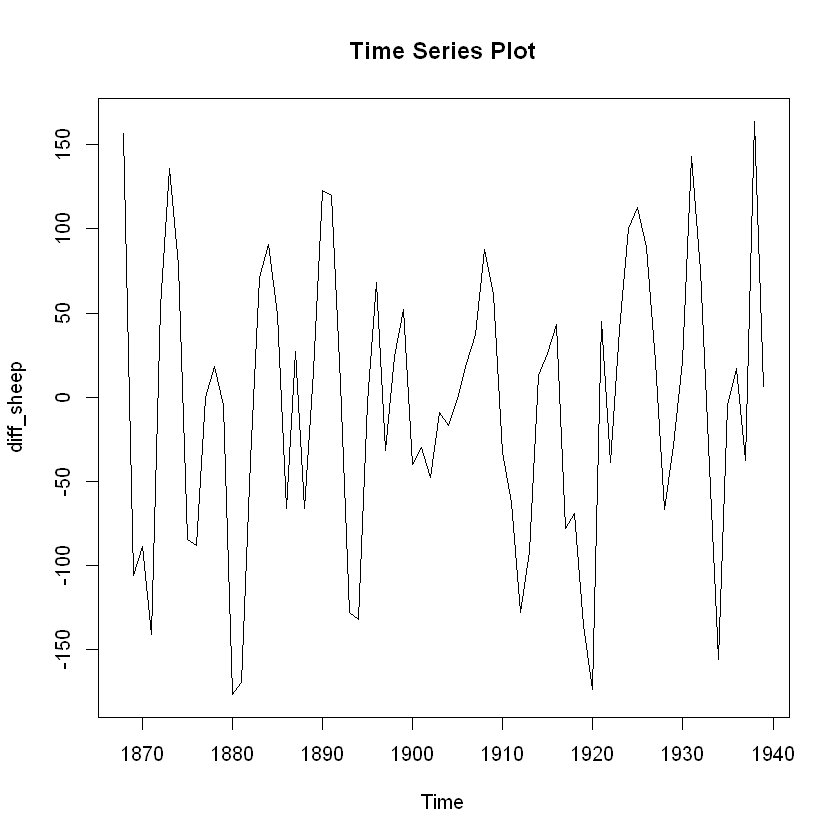

In [40]:
plot(diff_sheep , main = "Time Series Plot")

- 차분한 데이터의 시계열도표를 보니 0을 중심으로 왔다갔다하고 있다.
- 추세, 계절성, 이분산성이 모두 없어보인다. -> 더이상 차분할 필요 없어보이지만 단위근 검정으로 한번 더 확인

In [569]:
# 평균 검정
t.test(diff_sheep) 


	One Sample t-test

data:  diff_sheep
t = -0.57185, df = 71, p-value = 0.5692
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -25.30075  14.02298
sample estimates:
mean of x 
-5.638889 


- 모형에 상수항이 들어가는지 알아보기 위해 가설 검정 $H_0: \mu =0$ $vs.$ $H_1: \mu \neq 0$ 을 실시했다.
- t-검정을 했을 때 유의 확률이 0.5692이므로 유의 수준 0.05 하에서 영가설을 기각하지 못하여 평균은 0이다. => 모형에 상수항이 없다.

In [571]:
# 상수항이 없는 단위근 검정
adfTest(diff_sheep, lags = 2, type = "nc")

Warning message in adfTest(diff_sheep, lags = 2, type = "nc"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -6.7913
  P VALUE:
    0.01 

Description:
 Sun Dec 18 13:29:25 2022 by user: user


- $H_0:$ 단위근이 있다 $vs.$ $H_1:$ 단위근이 없다 (상수항이 없는 단위근 검정)를 실시하였다.
- 유의확률이 <0.01로 유의수준 0.05 하에서 영가설이 기각되어 단위근이 없다고 판단한다. => 더이상 차분할 필요 없음

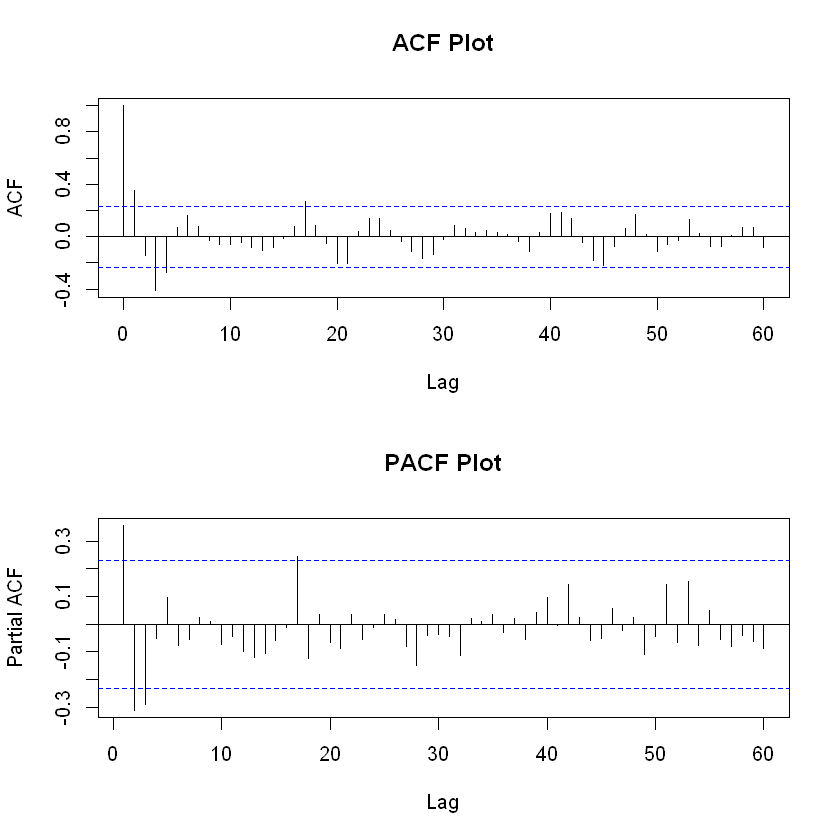

In [577]:
par(mfrow= c(2,1))
acf(diff_sheep , main = "ACF Plot",lag.max = 60)
pacf(diff_sheep , main = "PACF Plot",lag.max = 60)
par(mfrow= c(1,1))

- 차분한 데이터의 PACF Plot을 보면 시차가 3일 때까지 부분자기상관계수가 유의하다. 그러므로 AR의 차수는 3이 적합해보인다.
- 차분한 데이터의 ACF Plot을 보면 시차가 1일 때까지 자기상관계수가 유의하다. 그러므로 MA의 차수는 1이 적합해보인다.

=> 문제에서는 ARIMA(3,1,0)을 가정했지만 ARIMA(3,1,1)의 모형도 적합해서 비교해 볼 필요가 있을 것 같다.

### 2-(4) 양의 개체 수의 다음 3년 예측값 계산

|연도|1935|1936|1937|1938|1939|
|:---:|:---:|:---:|:---:|:---:|:---:|
|양(단위:백만마리)|1648|1665|1627|1791|1797|

$\hat{\phi}_1 = 0.42, \hat{\phi}_2 = -0.20, \hat{\phi}_3 = -0.3$

시점 n으로부터 $l$-시차 후의 관측값은

$Z_{n+l} = Z_{n+l-1} + \phi_1 (Z_{n+l-1} -Z_{n+l-2}) + \phi_2 (Z_{n+l-2} - Z_{n+l-3}) + \phi_3 (Z_{n+l-3} - Z_{n+l-4}) +\epsilon_{n+l} $ 

이므로

$\hat{Z}_{73}(1) =  Z_{n} + \hat{\phi}_1 (Z_{n} -Z_{n-1}) + \hat{\phi}_2 (Z_{n-1} - Z_{n-2}) + \hat{\phi}_3 (Z_{n-2} - Z_{n-3})$  
= $1797 + 0.42 \times (1797 - 1791) -0.20 \times (1791 - 1627) -0.3 \times(1627 - 1665) =  1778.12$

$\hat{Z}_{73}(2) =  \hat{Z}_{n}(1) + \hat{\phi}_1 (\hat{Z}_{n}(1) -Z_{n}) + \hat{\phi}_2 (Z_{n} - Z_{n-1}) + \hat{\phi}_3 (Z_{n-1} - Z_{n-2})$  
= $1778.12 + 0.42 \times (1778.12 - 1797) -0.20 \times (1797 - 1791) -0.3 \times(1791 - 1627) = 1719.7904$

$\hat{Z}_{73}(3) =  \hat{Z}_{n}(2) + \hat{\phi}_1 (\hat{Z}_{n}(2) -\hat{Z}_{n}(1)) + \hat{\phi}_2 (\hat{Z}_{n}(1) - Z_{n}) + \hat{\phi}_3 (Z_{n} - Z_{n-1})$  
= $1719.7904 + 0.42 \times (1719.7904 - 1778.12) -0.20 \times (1778.12 - 1797) -0.3 \times(1797 - 1791) = 1697.267968  $ 

이다.

=> $\hat{Z}_n(1) = 1778.12 , \hat{Z}_n(2) = 1719.79 , \hat{Z}_n(3) = 1697.27$

In [574]:
phi1 = 0.42 ; phi2 = -0.20 ; phi3 = -0.3

# Z_73(1)
1797 + 0.42*(1797 - 1791) -0.20 * (1791 - 1627) -0.3 *(1627 - 1665)
# Z_73(2)
1778.12 + 0.42 * (1778.12 - 1797) -0.20 * (1797 - 1791) -0.3 *(1791 - 1627) 
# Z_73(3)
1719.7904 + 0.42 * (1719.7904 - 1778.12) -0.20 * (1778.12 - 1797) -0.3 * (1797 - 1791)

[1] 1778.12

[1] 1719.79

[1] 1697.268

## 3. [hsales] 1973년 이후 미국에서 단독 주택의 월별 거래량

In [578]:
# 데이터 확인
head(hsales, 24)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1973,55,60,68,63,65,61,54,52,46,42,37,30
1974,37,44,55,53,58,50,48,45,41,34,30,24


### 3-(1) 시계열 그림

[1] "평균: 52.29"


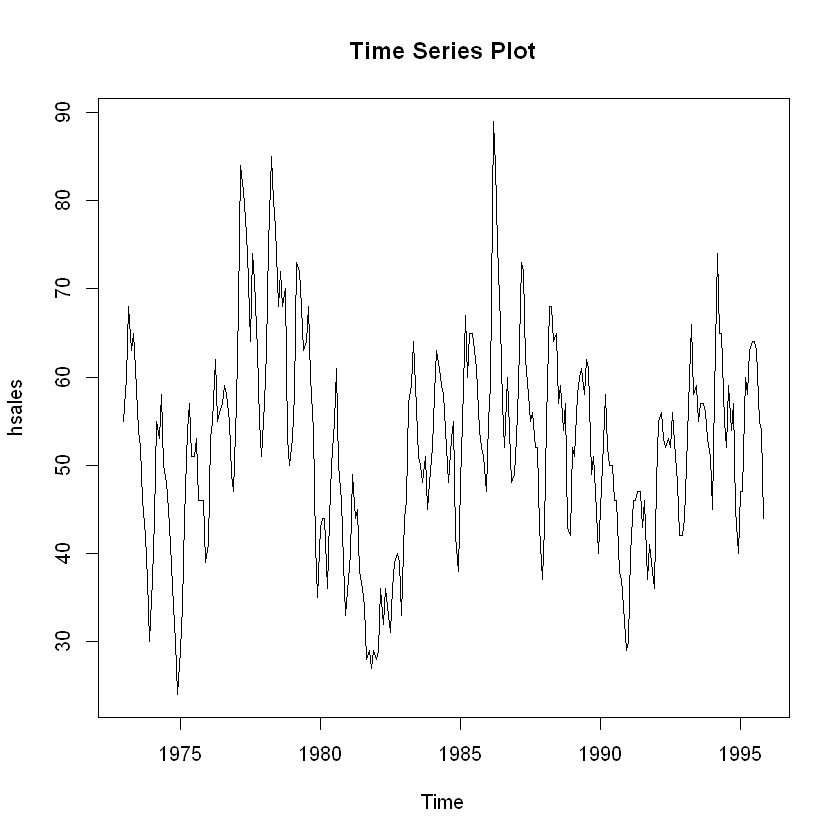

In [579]:
plot(hsales , main = "Time Series Plot")
print(paste0("평균: ", round(mean(hsales),2)))

- 계절성이 있어보인다.
- 추세는 없어보인다.
- 이분산성이 있는지는 잘 모르겠다. => Breusch-Pagan 검정 실시

### 3-(2) 변수변환

In [580]:
dt <- data.table(t = 1:length(hsales),
                 z = hsales)

In [581]:
bptest(lm(z~t, dt))


	studentized Breusch-Pagan test

data:  lm(z ~ t, dt)
BP = 11.849, df = 1, p-value = 0.0005769


- 이분산성이 있는지 확인하기 위해 Breusch-Pagan의 등분산성 검정을 실시했다.
- $H_0: 등분산이다. vs. H_1: 이분산이다.$ 
- 유의확률이 <0.001 이므로 영가설이 기각되어 원자료 hsales는 이분산성이 있다. => 변수 변환이 필요하다.

In [582]:
# 변수변환 비교
dt[, ln_z := log(z)]
dt[, sqrt_z := sqrt(z)]
dt[, boxcox_z := BoxCox(z,lambda= "auto")]

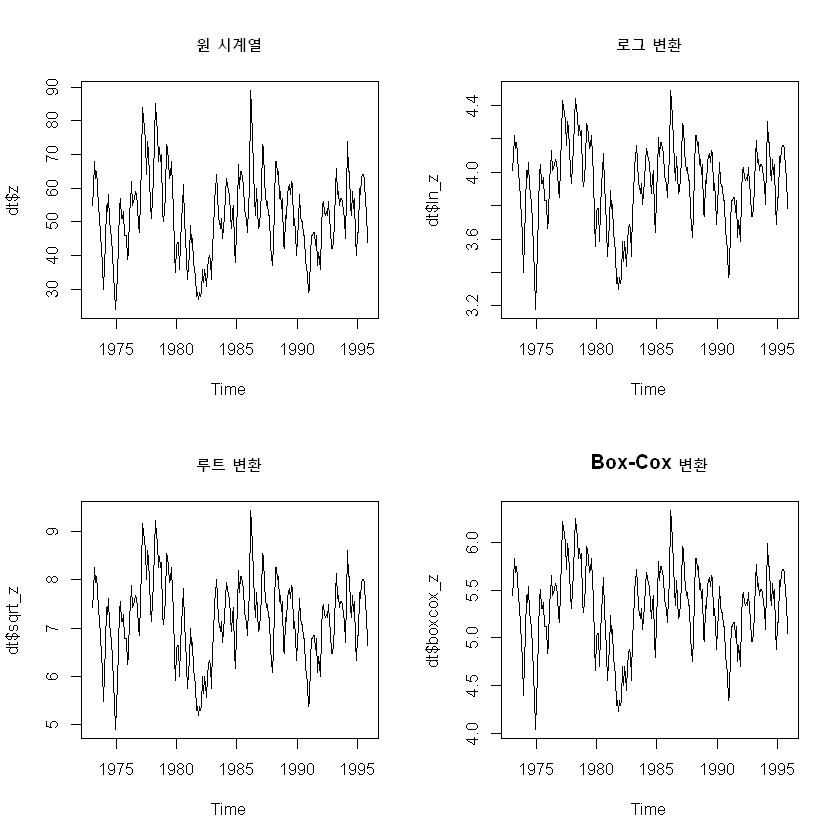

In [583]:
par(mfrow = c(2,2))
plot(dt$z , main = "원 시계열") ; plot(dt$ln_z , main= "로그 변환") ; plot(dt$sqrt_z,main =  "루트 변환") ; plot(dt$boxcox_z, main = "Box-Cox 변환")
par(mfrow = c(1,1))

- 로그 변환, 루트 변환, Box-Cox 변환의 시계열 도표에 큰 차이가 없어보인다.

In [584]:
t =  rep(1:12 , 23) # s=12인 계절성이 있음을 고려
bptest(lm(dt$ln_z~t[1:(length(t)-1)]))
bptest(lm(dt$sqrt_z~t[1:(length(t)-1)]))
bptest(lm(dt$boxcox_z~t[1:(length(t)-1)]))


	studentized Breusch-Pagan test

data:  lm(dt$ln_z ~ t[1:(length(t) - 1)])
BP = 2.9327, df = 1, p-value = 0.0868



	studentized Breusch-Pagan test

data:  lm(dt$sqrt_z ~ t[1:(length(t) - 1)])
BP = 6.6179, df = 1, p-value = 0.0101



	studentized Breusch-Pagan test

data:  lm(dt$boxcox_z ~ t[1:(length(t) - 1)])
BP = 3.8763, df = 1, p-value = 0.04897


- 변수 변환 후에도 이분산성이 남아있는지 확인하기 위해 계절성을 고려하여 Breusch-Pagan의 등분산성 검정을 실시했다.
- $H_0: 등분산이다. vs. H_1: 이분산이다.$ 

|변수변환|유의확률|유의수준|영가설 기각여부|결론|
|:---:|:---:|:---:|:---:|:---:|
|log|0.0868|0.05|x|등분산|
|root|0.0101|0.05|o|이분산|
|Box-Cox|0.0489|0.05|o|이분산|

- log 변환된 data만 등분산이므로 log변환된 data로 분석하겠다.

### 3-(3) 정상시계열로 변환

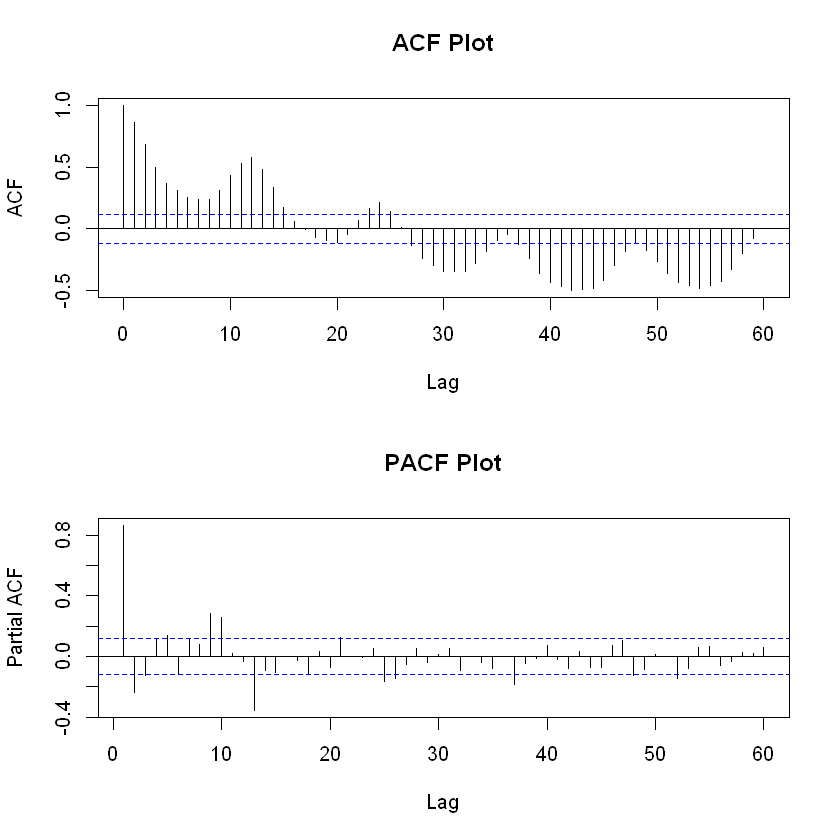

In [585]:
ln_z = ts(log(as.vector(hsales)))
par(mfrow = c(2,1))
acf(ln_z , lag.max = 60,main = "ACF Plot")
pacf(ln_z, lag.max = 60, main = "PACF Plot")
par(mfrow = c(1,1))

- acf가 서서히 감소하여 확률적 추세가 의심되고, 계절주기 12의 영향을 받는 것 같다. => 계절 차분이 필요해보인다.
- pacf가 1-시차에서 유의, 계절 주기 근처에서 유의하다.

`geom_smooth()` using formula 'y ~ x'



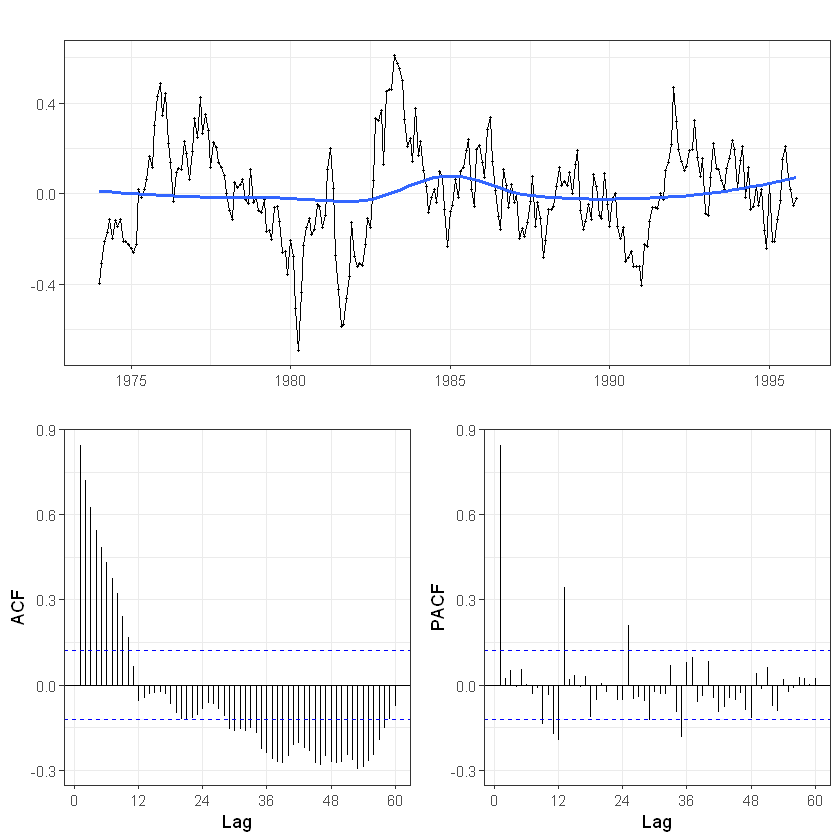

In [586]:
##### 계절차분
sdiff_log_hsales <- diff(log(hsales), lag=12)

ggtsdisplay(sdiff_log_hsales, lag.max  = 60,
            theme = theme_bw(),
            smooth=T)

- 계절주기를 12로 하여 계절차분을 진행하였더니 ACF가 서서히 감소하여 여전히 확률적 추세가 있어보인다. => 차분이 더 필요한지 단위근 검정 실시

In [587]:
# 평균 검정
t.test(sdiff_log_hsales) 


	One Sample t-test

data:  sdiff_log_hsales
t = 0.18942, df = 262, p-value = 0.8499
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.02358688  0.02860794
sample estimates:
 mean of x 
0.00251053 


- 모형에 상수항이 들어가는지 알아보기 위해 계절차분한 data에 대해 가설 검정 $H_0: \mu =0$ $vs.$ $H_1: \mu \neq 0$ 을 실시했다.
- t-검정을 했을 때 유의확률이 0.8499이므로 유의수준 0.05 하에서 영가설을 기각하지 못해 평균은 0이다. => 모형에 상수항이 없다.

In [588]:
# 상수항이 없는 단위근 검정
adfTest(sdiff_log_hsales, lags = 2, type = "nc")

Warning message in adfTest(sdiff_log_hsales, lags = 2, type = "nc"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -4.0676
  P VALUE:
    0.01 

Description:
 Sun Dec 18 13:40:36 2022 by user: user


- $H_0:$ 단위근이 있다 $vs.$ $H_1:$ 단위근이 없다 (상수항이 없는 단위근 검정)를 실시하였다.
- 유의확률이 <0.01로 유의수준 0.05 하에서 영가설이 기각되어 단위근이 없다고 판단한다. => 더이상 차분할 필요 없음

### 3-(4) 모형 식별

`geom_smooth()` using formula 'y ~ x'



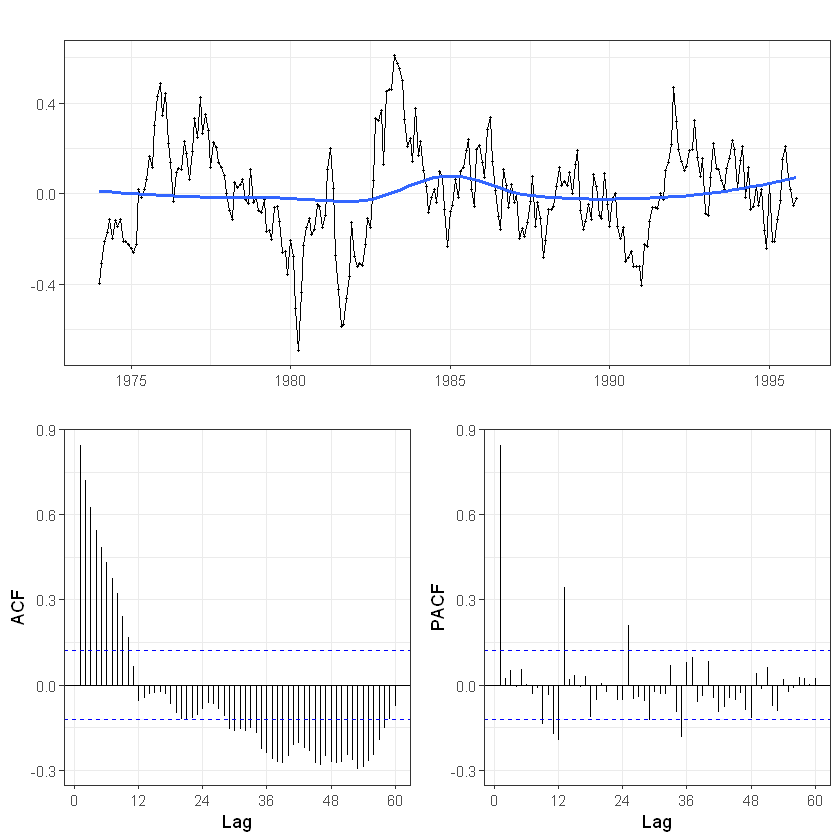

In [589]:
ggtsdisplay(sdiff_log_hsales, lag.max  = 60,
            theme = theme_bw(),
            smooth=T)

- ACF가 서서히 감소하는 모양이 MA(0) , SMA(0) 같지만, 시차가 30이상일 때 유의한 모양에 대해서 잘 모르겠다.
- PACF가 1-시차에서 유의하다 => AR(1)
- PACF가 12-시차 , 24-시차, 36-시차, 48-시차, ... 에서 점점 감소하고 있다. => SAR(0)

따라서 모형은 $ARIMA(1,0,0)(0,1,0)_{12}$가 적합해 보인다.  
ACF Plot으로 MA의 차수를 잘 판단하지 못하겠으므로 $ARIMA(1,0,1)(0,1,0)_{12}$, $ARIMA(1,0,0)(0,1,1)_{12}$ 도 함께 적합해본다.

### 3-(5) 모형 적합

In [590]:
model1 = arima(dt$ln_z, order = c(1,0,0), 
             seasonal = list(order = c(0,1,0),  # 계절
                             period = 12)) # 계절주기
summary(model1)


Call:
arima(x = dt$ln_z, order = c(1, 0, 0), seasonal = list(order = c(0, 1, 0), period = 12))

Coefficients:
         ar1
      0.8517
s.e.  0.0323

sigma^2 estimated as 0.01281:  log likelihood = 199.16,  aic = -394.31

Training set error measures:
                      ME      RMSE        MAE          MPE     MAPE      MASE
Training set 0.001144324 0.1107011 0.08738421 -0.003170397 2.242578 0.8744655
                    ACF1
Training set -0.02632799

In [591]:
coeftest(model1)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1 0.851740   0.032325  26.349 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [592]:
model2 = arima(dt$ln_z, order = c(1,0,1), 
             seasonal = list(order = c(0,1,0),  # 계절
                             period = 12)) # 계절주기
model2 


Call:
arima(x = dt$ln_z, order = c(1, 0, 1), seasonal = list(order = c(0, 1, 0), period = 12))

Coefficients:
         ar1      ma1
      0.8594  -0.0274
s.e.  0.0378   0.0769

sigma^2 estimated as 0.01281:  log likelihood = 199.22,  aic = -392.44

In [593]:
coeftest(model2)


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)    
ar1  0.859365   0.037785 22.7435   <2e-16 ***
ma1 -0.027448   0.076865 -0.3571    0.721    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [594]:
model3 = arima(dt$ln_z, order = c(1,0,0), 
             seasonal = list(order = c(0,1,1),  # 계절
                             period = 12)) # 계절주기
model3 


Call:
arima(x = dt$ln_z, order = c(1, 0, 0), seasonal = list(order = c(0, 1, 1), period = 12))

Coefficients:
         ar1     sma1
      0.9170  -1.0000
s.e.  0.0254   0.0719

sigma^2 estimated as 0.006808:  log likelihood = 263.67,  aic = -521.35

In [595]:
coeftest(model3)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1   0.916987   0.025416  36.079 < 2.2e-16 ***
sma1 -0.999996   0.071895 -13.909 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


`model1`: $ARIMA(1,0,0)(0,1,0)_{12}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.8517| 0.0323|26.349|<0.001|-394.31|

`model2`: $ARIMA(1,0,1)(0,1,0)_{12}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.8594| 0.0378|22.7435|<0.001|-392.44|
|$\theta_1$|-0.0274|0.0769|-0.3571|0.721||

`model3`:$ARIMA(1,0,0)(0,1,1)_{12}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.9170| 0.0254|36.079|<0.001|-521.35|
|$\Theta_1$|-1.0| 0.0719|-13.909|<0.001||

### 3-(6) 더 좋은 모형 선택

파라미터의 수를 고려해도 AIC의 차이가 크기 때문에 AIC가 -521.35으로 제일 작은 `model3`: $ARIMA(1,0,0)(0,1,1)_{12}$를 선택한다.

**<추정된 최종모형식>**

$(1-0.92B)(1-B^{12})lnZ_t = (1+B^{12})\epsilon_t$ , $\epsilon_t \sim WN(0,0.007)$

### 3-(7) 잔차 검정


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(0,1,1)[12]
Q* = 17.895, df = 22, p-value = 0.7122

Model df: 2.   Total lags used: 24




	studentized Breusch-Pagan test

data:  lm(model3$residuals ~ t)
BP = 0.046987, df = 1, p-value = 0.8284


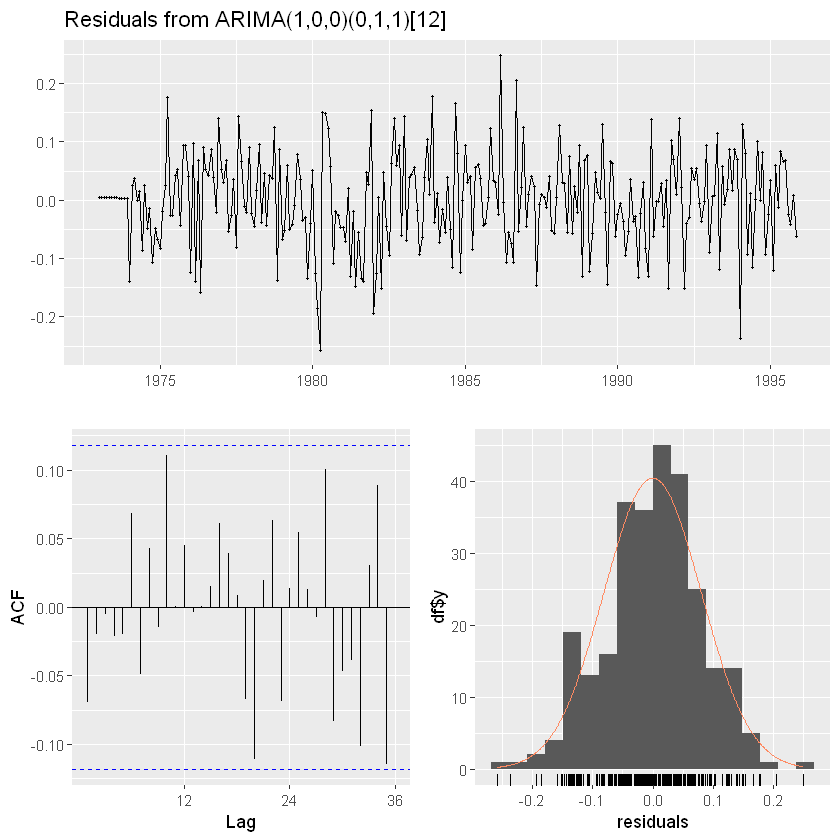

In [596]:
checkresiduals(model3)
t = 1:275
bptest(lm(model3$residuals~t))

- 잔차가 등분산인지 검정하기 위해 Breusch-Pagan 검정을 실시하였더니 유의확률 0.8284로 유의수준 0.05 하에서 영가설($H_0$:등분산)을 기각할 수 없어 등분산이라고 판단한다.
-  Ljung-Box 검정 $H_0: \rho_1 = \rho_2 = \rho_3 = ... = \rho_k = 0$  $vs.$  $H_1: not H_0$
- Ljung-Box 검정의 결과로 유의확률이 0.7122이므로 유의수준 0.05하에서 영가설을 기각할 수 없어 잔차는 백색 잡음이다.
- ACF Plot에서 acf가 모든 시차에서 유의하지 않다.
- 잔차의 히스토그램을 보니 정규분포와 유사하다.


### 3-(8) 다음 2년간 주택의 월별 거래량 예측

In [355]:
forecast(model3, h=25)

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Dec 1995       3.691484 3.583401 3.799567 3.526185 3.856783
Jan 1996       3.819071 3.672476 3.965665 3.594873 4.043268
Feb 1996       3.938916 3.766505 4.111328 3.675236 4.202597
Mar 1996       4.116767 3.925330 4.308205 3.823989 4.409546
Apr 1996       4.093399 3.887324 4.299473 3.778235 4.408562
May 1996       4.091807 3.874193 4.309420 3.758996 4.424617
Jun 1996       4.047209 3.820355 4.274062 3.700267 4.394151
Jul 1996       3.989536 3.755205 4.223866 3.631158 4.347914
Aug 1996       4.012349 3.771923 4.252776 3.644649 4.380050
Sep 1996       3.927933 3.682511 4.173354 3.552593 4.303273
Oct 1996       3.907657 3.658129 4.157185 3.526036 4.289277
Nov 1996       3.770116 3.517206 4.023027 3.383323 4.156909
Dec 1996       3.678579 3.422143 3.935014 3.286394 4.070763
Jan 1997       3.807237 3.547903 4.066571 3.410620 4.203854
Feb 1997       3.928065 3.666286 4.189844 3.527708 4.328421
Mar 1997       4.106816 3.843004 4.37062

`다음 2년간의 주택 월별 거래량 예측값`: forecast()를 사용하여 다음 24개의 data를 예측하였다.
|년도|1월|2월|3월|4월|5월|6월|7월|8월|9월|10월|11월|12월|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1996|3.819|3.938|4.116|4.093|4.091|4.047|3.989|4.012|3.927|3.907|3.770|3.678|
|1997|3.807| 3.928|4.106|4.084|4.083|4.039|3.982| 4.005|3.922|3.902|3.765|3.674|

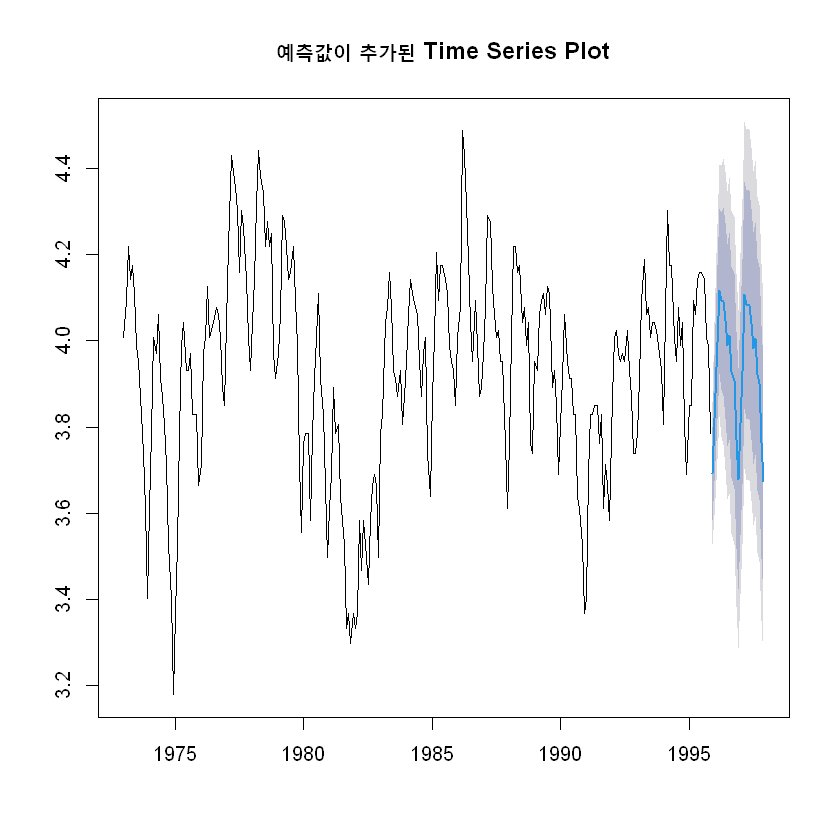

In [597]:
plot(forecast(model3, h=25,level = c(80, 95)) , main = "예측값이 추가된 Time Series Plot")

## 4. [ukcars] 영국의 분기별 승용차 생산 대수 (단위: 천 대)

In [598]:
# 데이터 확인
head(ukcars, 8)

,Qtr1,Qtr2,Qtr3,Qtr4
1977,330.371,371.051,270.670,343.880
1978,358.491,362.822,261.281,240.355


### 4-(1) 시계열 그림

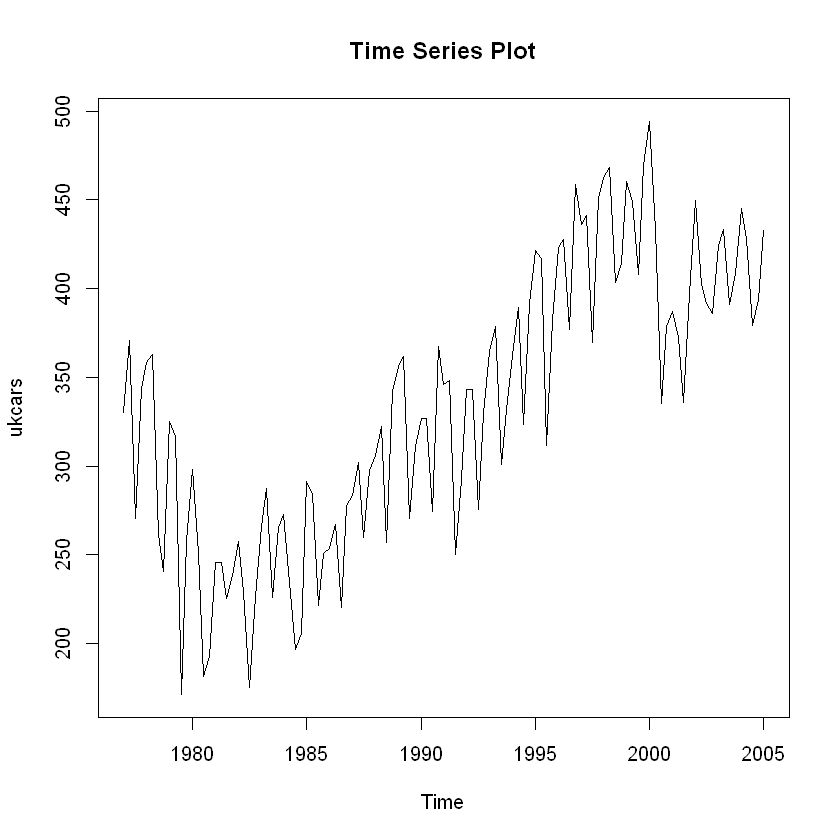

In [599]:
plot(ukcars, main = "Time Series Plot")

- 추세가 있어보인다.
- 폭이 좁고 위로 볼록한 모양이 반복되고 있다. => 계절성 있어보임
- 이분산성은 없어 보인다.

### 4-(2) 변수 변환

In [382]:
t = rep((1:4),29) # 계절 주기 고려
bptest(lm(ukcars~t[1:113]))


	studentized Breusch-Pagan test

data:  lm(ukcars ~ t[1:113])
BP = 1.2592, df = 1, p-value = 0.2618


- 이분산성이 있는지 확인하기 위해 계절성을 고려하여 Breusch-Pagan의 등분산성 검정을 실시했다.
- $H_0: 등분산이다. vs. H_1: 이분산이다.$ 
- 유의확률이 0.2618 이므로 유의수준 0.05 하에서 영가설을 기각하지 못해 원자료 ukcars는 등분산이다. => 변수 변환이 필요없다.

### 4-(3) train/test data 분할

In [600]:
train = ts(ukcars[1:(length(ukcars)-9)] , frequency = 4,start = c(1977, 1))
head(train , 8)

,Qtr1,Qtr2,Qtr3,Qtr4
1977,330.371,371.051,270.670,343.880
1978,358.491,362.822,261.281,240.355


- `train data`: 1977년~2002년의 분기별 승용차 생산 대수

In [604]:
test = ts(ukcars[(length(ukcars)-9):length(ukcars)] , frequency = 4,start = c(2003, 1))
head(test,8)

,Qtr1,Qtr2,Qtr3,Qtr4
2003,385.890,424.325,433.280,391.213
2004,408.740,445.458,428.202,379.048


- `test data`: 2003년~2004년의 분기별 승용차 생산 대수

### 4-(4) train data에 이동평균 모형 적합, 마지막 2년 승용차 생산 대수 예측

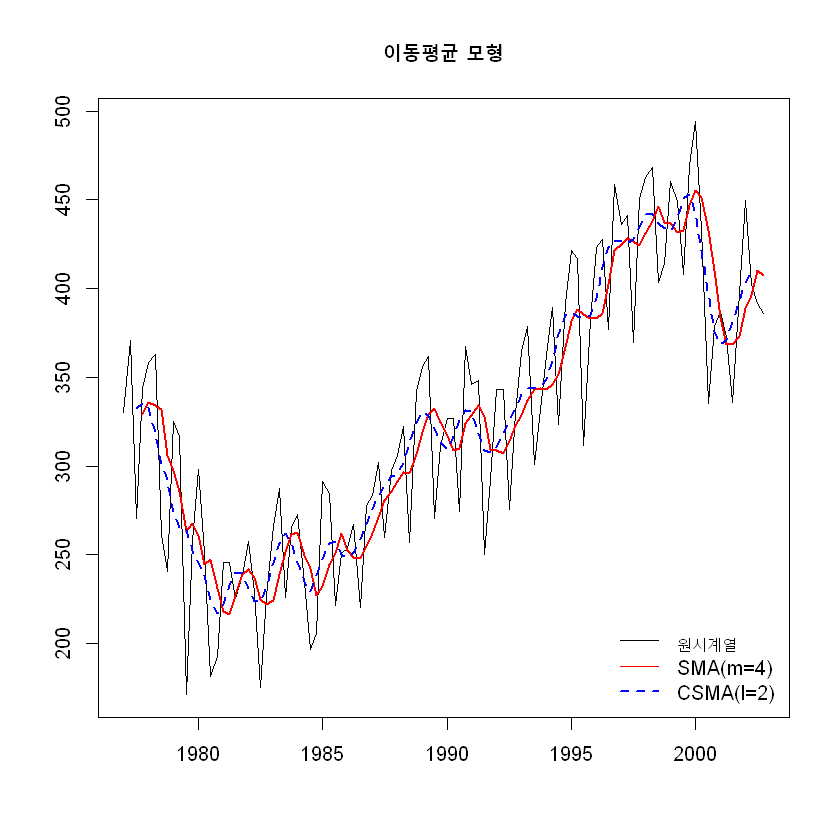

In [609]:
plot.ts(train, ylab = "" , xlab = "", main = "이동평균 모형")
lines(SMA(train , n=4) , col = "red" , lwd=2) # 단순이동평균, window size = 4, 앞에 3개 NA
lines(ma(train , order = 4) , col = "blue" , lty=2, lwd=2) # 중심이동 평균, 앞뒤 2개씩 NA
legend("bottomright" , lty = c(1,1,2), col = c("black" , "red" , "blue" ) ,
       lwd = c(1,1,2) , 
       c("원시계열" , "SMA(m=4)" ,"CSMA(l=2)" ), 
       bty = "n")

- 주기가 4인 계절성이 있는 data이므로 단순이동평균과 중심이동평균의 window size = 4 로 설정했다.
- 단순이동평균은 SMA(), 중심이동평균은 ma() 함수를 사용하였다.
- 계절성분이 smoothing 되고, 각 이동평균모형이 전체적인 data의 추세를 잘 따라가고 있다.

In [611]:
# 예측값: 단순이동평균 모형
predict(SMA(train , n=4),8)

Warning message in ets(object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend, :
"Missing values encountered. Using longest contiguous portion of time series"


        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2003 Q1       408.3898 396.2314 420.5481 389.7951 426.9844
2003 Q2       409.1518 386.8974 431.4062 375.1166 443.1870
2003 Q3       409.7614 377.1592 442.3637 359.9005 459.6223
2003 Q4       410.2492 367.2903 453.2080 344.5493 475.9490
2004 Q1       410.6393 357.4912 463.7874 329.3563 491.9223
2004 Q2       410.9515 347.8864 474.0166 314.5017 507.4012
2004 Q3       411.2012 338.5484 483.8539 300.0883 522.3140
2004 Q4       411.4009 329.5161 493.2858 286.1688 536.6330

In [612]:
ma_pred = c(408.3898,409.1518,409.7614,410.2492,410.6393,410.9515,411.2012, 411.4009)

`마지막 2년 승용차 생산 대수 예측(단순이동평균 모형)`: predict()를 사용하여 다음 8개의 data를 예측함.
|년도|1분기|2분기|3분기|4분기|
|:---:|:---:|:---:|:---:|:---:|
|2003|408.3898|409.1518|409.7614|410.2492|
|2004|410.6393|410.9515|411.2012|411.4009|

In [614]:
# 예측값: 중심이동평균 모형
predict(ma(train , order = 4), 10)

Warning message in ets(object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend, :
"Missing values encountered. Using longest contiguous portion of time series"


        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2002 Q3       413.3221 405.0795 421.5648 400.7161 425.9282
2002 Q4       416.9118 399.9405 433.8831 390.9565 442.8671
2003 Q1       419.7835 393.4694 446.0977 379.5395 460.0275
2003 Q2       422.0809 386.2428 457.9190 367.2713 476.8906
2003 Q3       423.9188 378.6202 469.2175 354.6405 493.1972
2003 Q4       425.3892 370.8318 479.9466 341.9508 508.8275
2004 Q1       426.5654 363.0272 490.1037 329.3921 523.7388
2004 Q2       427.5065 355.3035 499.7094 317.0816 537.9314
2004 Q3       428.2593 347.7224 508.7961 305.0888 551.4298
2004 Q4       428.8615 340.3219 517.4011 293.4519 564.2712

In [615]:
cma_pred = c(419.7835,422.0809,423.9188,425.3892,426.5654,427.5065,428.2593,428.8615)

`마지막 2년 승용차 생산 대수 예측(중심이동평균 모형)`: predict()를 사용하여 다음 10개의 data를 예측함.
|년도|1분기|2분기|3분기|4분기|
|:---:|:---:|:---:|:---:|:---:|
|2003|419.7835|422.0809|423.9188|425.3892|
|2004|426.5654| 427.5065|428.2593|428.8615|

Warning message in ets(object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend, :
"Missing values encountered. Using longest contiguous portion of time series"
Warning message in ets(object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend, :
"Missing values encountered. Using longest contiguous portion of time series"


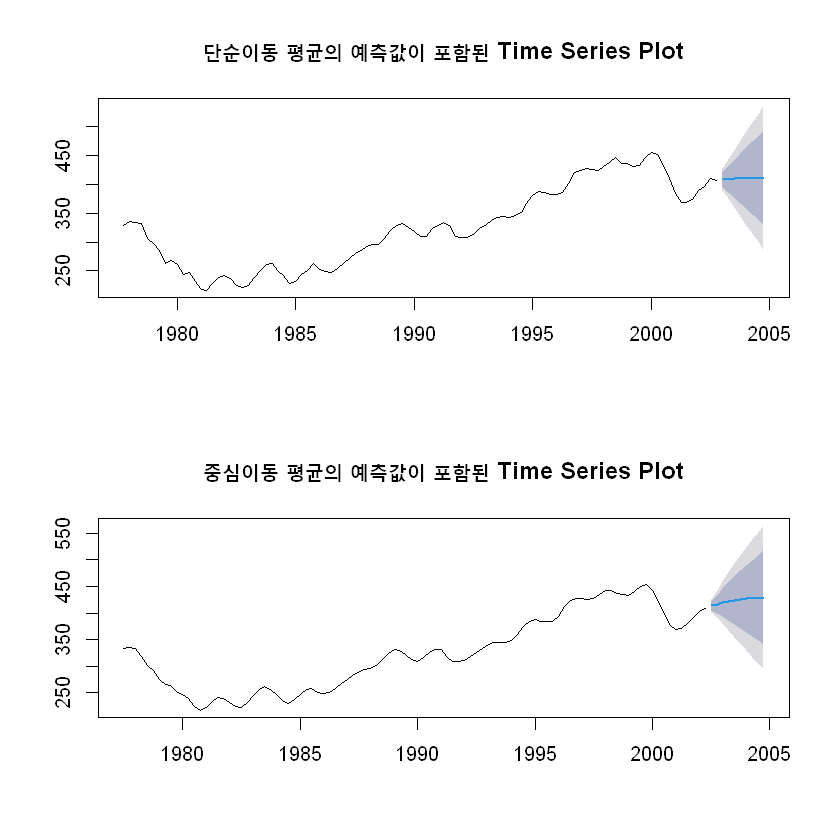

In [623]:
par(mfrow=c(2,1))
plot(predict(SMA(train , n=4),8), main = "단순이동 평균의 예측값이 포함된 Time Series Plot")
plot(predict(ma(train , order = 4), 10), main = "중심이동 평균의 예측값이 포함된 Time Series Plot")
par(mfrow=c(1,1))

- 눈으로 보기에는 중심이동 평균 모형이 더 예측을 잘 한 것 같다.

### 4-(5) train data에 지수평활 모형 적합, 마지막 2년 승용차 생산 대수 예측

In [625]:
model = hw(train , seasonal = "additive" , h=8)
model$model

Holt-Winters' additive method 

Call:
 hw(y = train, h = 8, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.6177 
    beta  = 0.0019 
    gamma = 1e-04 

  Initial states:
    l = 333.3573 
    b = 0.8663 
    s = 0.5052 -46.5605 22.4941 23.5611

  sigma:  27.0772

     AIC     AICc      BIC 
1178.820 1180.735 1202.620 

- 주기가 4인 계절성이 있으므로 hw()함수를 사용하여 Holt-Winters의 가법계절지수평활 모형을 적합했다.
- $\alpha = 0.6177$ , $\beta = 0.0019$, $\gamma = 0.0001$이 최적의 모수로 추정되었다.
- $\hat{\sigma}^2$ = 27.0772

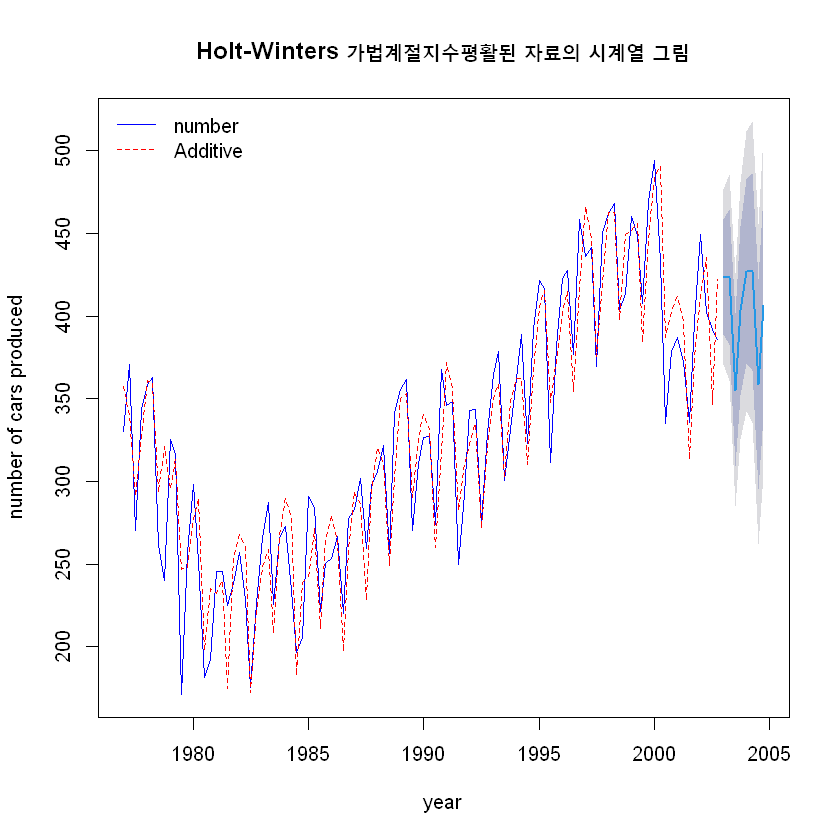

In [626]:
plot(model,  ylab="number of cars produced", xlab="year", lty=1, col="blue",
     main="Holt-Winters 가법계절지수평활된 자료의 시계열 그림")
lines(model$fitted, col="red", lty=2)
legend("topleft", lty=1:2, col=c("blue","red"), c("number", "Additive"),  bty = "n")

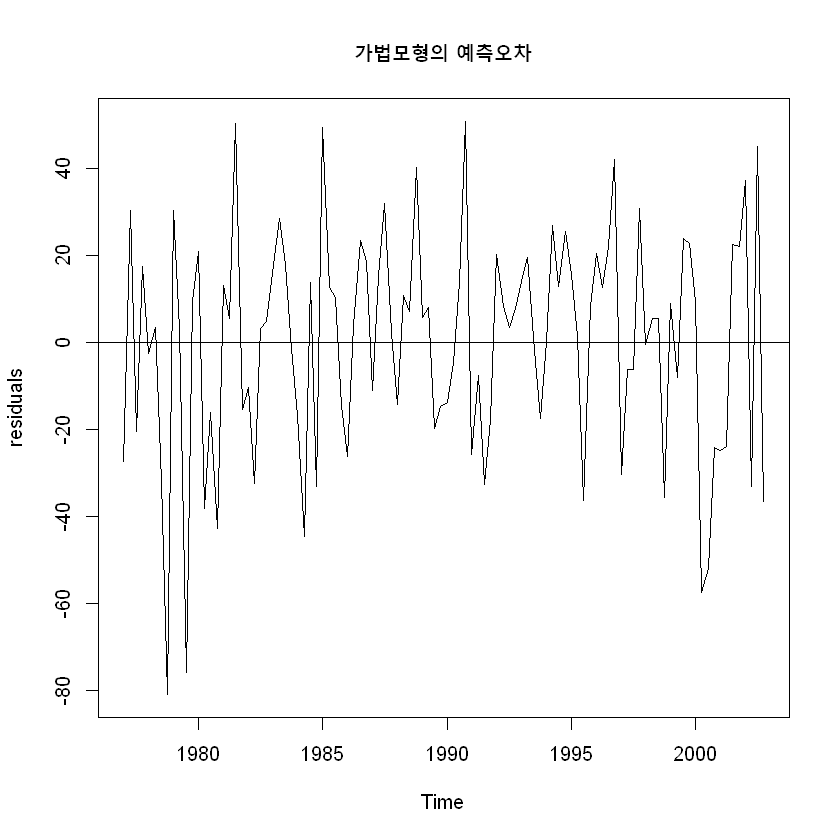

In [627]:
plot(resid(model),main = "가법모형의 예측오차" , ylab = "residuals")
abline(h=0)

- 적합한 가법계절지수평활 모형의 잔차가 0을 기준으로 잘 왔다갔다하고 있는 것 같다.

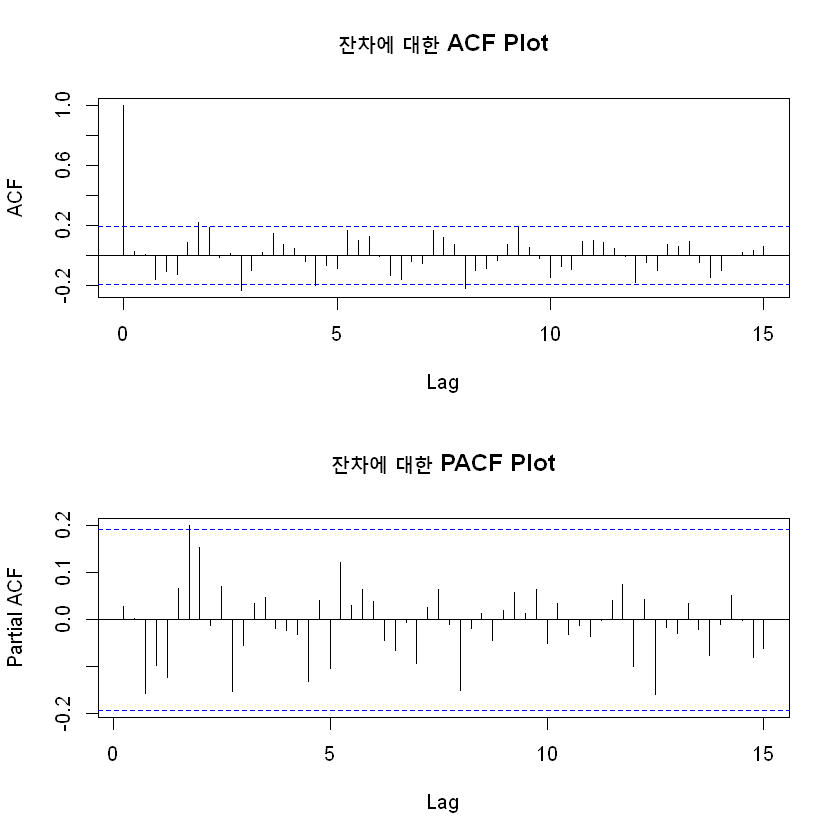

In [629]:
par(mfrow = c(2,1))
acf(resid(model) , main = "잔차에 대한 ACF Plot", lag.max = 60)
pacf(resid(model),main = "잔차에 대한 PACF Plot", lag.max = 60)
par(mfrow = c(1,1))

- ACF와 PACF 모두 거의 유의하지 않으므로 잔차는 백색잡음이다. => 잔차에 따로 모형을 걸어줄 필요x

In [630]:
# 예측값
model

        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2003 Q1       423.7983 389.0975 458.4992 370.7279 476.8687
2003 Q2       423.5532 382.7326 464.3739 361.1234 485.9831
2003 Q3       355.3400 309.1741 401.5059 284.7354 425.9447
2003 Q4       403.2351 352.2542 454.2160 325.2665 481.2036
2004 Q1       427.1340 371.7285 482.5395 342.3986 511.8694
2004 Q2       426.8889 367.3645 486.4133 335.8542 517.9236
2004 Q3       358.6757 295.2773 422.0741 261.7162 455.6351
2004 Q4       406.5707 339.5007 473.6408 303.9960 509.1455

In [631]:
expsmooting_pred = c(423.7983,423.5532,355.3400,403.2351,427.1340 ,426.8889,358.6757,406.5707)

`마지막 2년 승용차 생산 대수 예측(가법계절지수평활 모형)`
|년도|1분기|2분기|3분기|4분기|
|:---:|:---:|:---:|:---:|:---:|
|2003|423.7983|423.5532|355.3400|403.2351|
|2004|427.1340|426.8889|358.6757|406.5707|

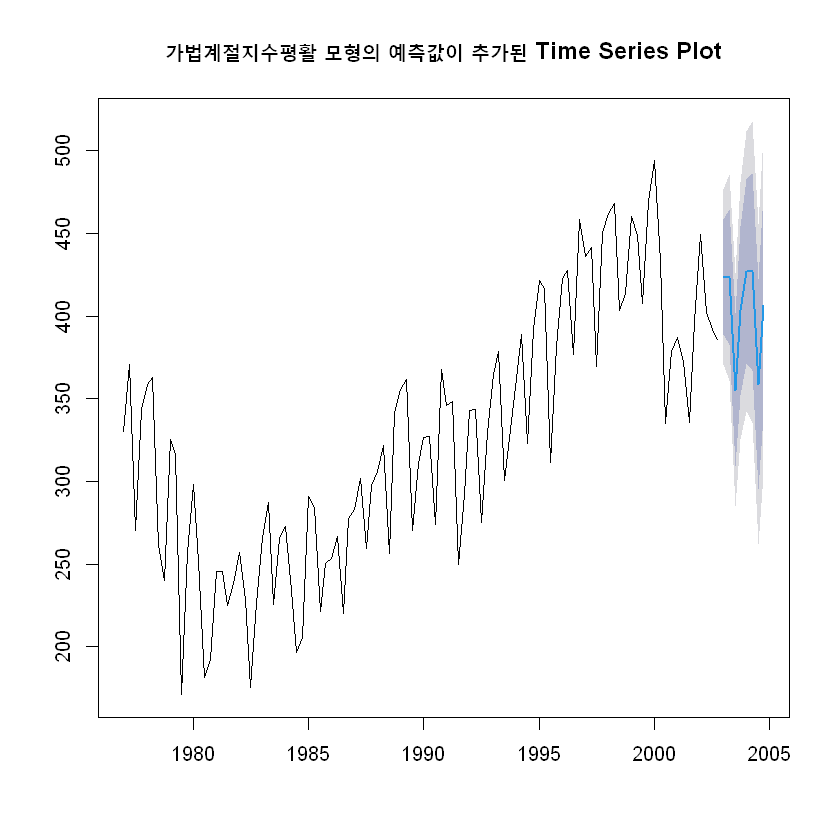

In [632]:
plot(model, main = "가법계절지수평활 모형의 예측값이 추가된 Time Series Plot")

### 4-(6) train data에 계절형 ARIMA 모형 적합, 마지막 2년 승용차 생산 대수 예측

`geom_smooth()` using formula 'y ~ x'



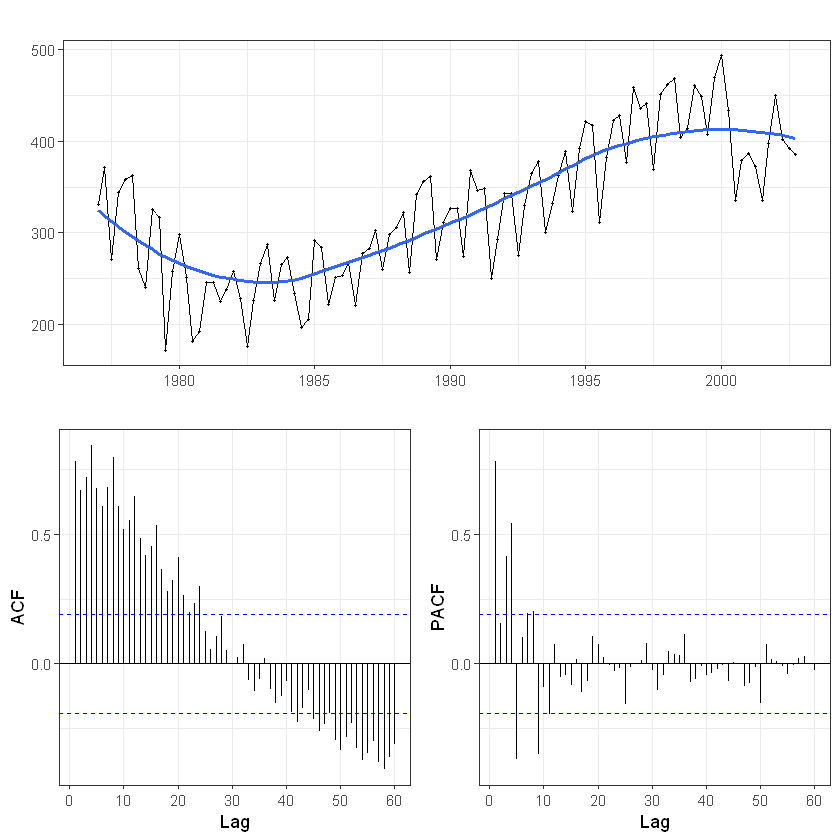

In [633]:
ggtsdisplay(train, lag.max  = 60,
            theme = theme_bw(),
            smooth=T)

- time series plot에서 계절성과 추세가 있어보인다.
- ACF가 서서히 감소하고 있어 확률적 추세가 의심된다 => 차분 필요
- PACF가 1-시차에서 유의하고, 계절주기 주변에서 유의하다. 

`geom_smooth()` using formula 'y ~ x'



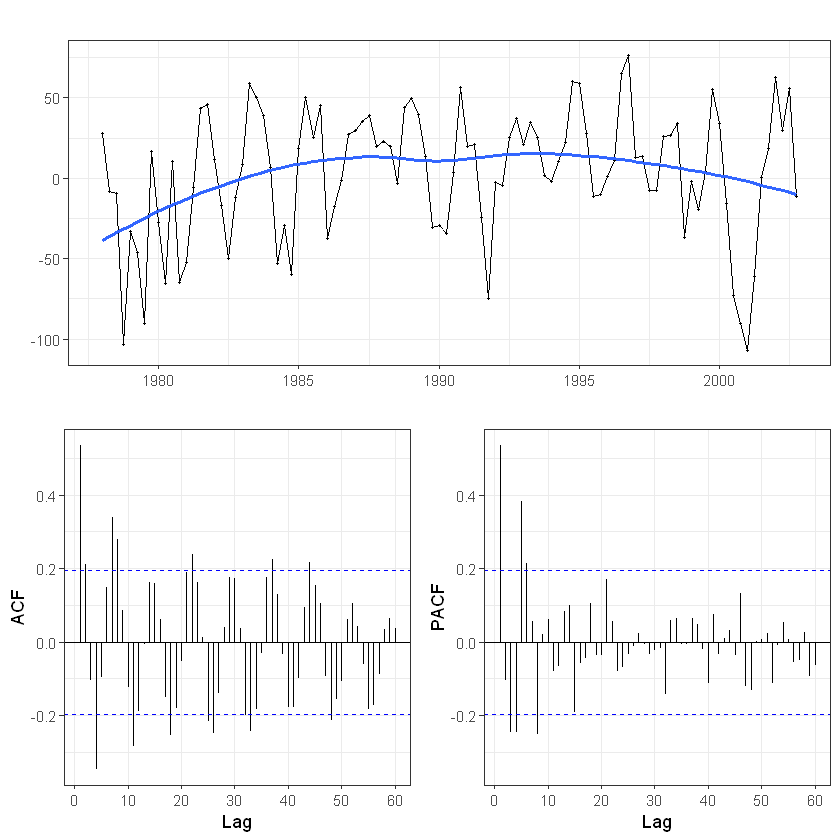

In [452]:
# 계절 차분
sdiff_z = diff(train , lag = 4)
ggtsdisplay(sdiff_z, lag.max  = 60,
            theme = theme_bw(),
            smooth=T)

- 계절주기 4로 계절차분을 하였더니 time series plot에서 추세와 계절성이 어느정도 잡힌 것 같다.
- ACF를 보니 확률적 추세도 제거된 것 같다.
- PACF가 1-시차에서 유의하고, 계절주기 주변에서 유의하다.
- 차분이 더 필요한지 단위근 검정을 실시하여 한번 더 확인한다.

In [634]:
# 평균 검정
t.test(sdiff_z) 


	One Sample t-test

data:  sdiff_z
t = 0.78431, df = 99, p-value = 0.4347
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.800365 11.075805
sample estimates:
mean of x 
  3.13772 


- 모형에 상수항이 들어가는지 알아보기 위해 가설 검정 $H_0: \mu =0$ $vs.$ $H_1: \mu \neq 0$ 을 실시했다.
- t-검정을 했을 때 유의확률이 0.4347이므로 유의수준 0.05 하에서 영가설을 기각하지 못해 평균은 0이다. => 모형에 상수항이 없다.

In [635]:
# 상수항이 없는 단위근 검정
adfTest(sdiff_z, lags = 2, type = "nc")

Warning message in adfTest(sdiff_z, lags = 2, type = "nc"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -5.902
  P VALUE:
    0.01 

Description:
 Sun Dec 18 14:06:36 2022 by user: user


- 차분이 더 필요한지 판단하기 위해 상수항이 없는 단위근 검정을 실시하였다.
- $H_0:$ 단위근이 있다 $vs.$ $H_1:$ 단위근이 없다
- 유의확률이 <0.01로 유의수준 0.05 하에서 영가설이 기각되어 단위근이 없다고 판단한다. => 더이상 차분할 필요 없음

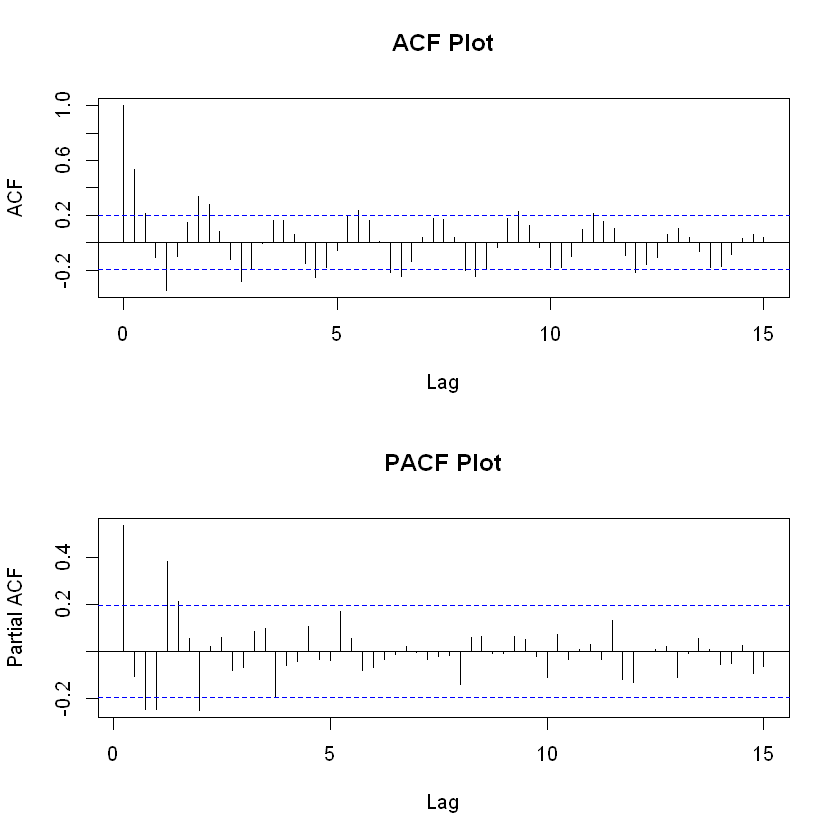

In [637]:
par(mfrow = c(2,1))
acf(sdiff_z , main = "ACF Plot" , lag.max= 60)
pacf(sdiff_z , main = "PACF Plot", lag.max= 60)
par(mfrow = c(1,1))

적합할 모형을 식별하기 위해 계절 차분된 train data에 대한 ACF Plot과 PACF Plot을 그렸다.

- ACF가 1-시차에서 유의하다. => MA(1)
- ACF가 4-시차, 8-시차, 12-시차, .... 에서 점점 감소하고 있다. => SMA(0)
- PACF가 1-시차에서 유의하다 => AR(1)
- PACF가 4-시차 , 8-시차에서 유의한데, 유의성의 정도가 크지 않은 것 같다. => SAR(2)/SAR(1)

따라서 모형은 $ARIMA(1,0,1)(2,1,0)_{4}$, $ARIMA(1,0,1)(1,1,0)_{4}$, $ARIMA(1,0,1)(1,1,1)_{4}$ 정도가 적합해 보인다.

In [638]:
model1 = arima(train, order = c(1,0,1), 
             seasonal = list(order = c(2,1,0),  # 계절
                             period = 4)) # 계절주기
summary(model1)


Call:
arima(x = train, order = c(1, 0, 1), seasonal = list(order = c(2, 1, 0), period = 4))

Coefficients:
         ar1      ma1     sar1     sar2
      0.8431  -0.2479  -0.7640  -0.2046
s.e.  0.0808   0.1479   0.1152   0.1147

sigma^2 estimated as 749.4:  log likelihood = -474.11,  aic = 958.23

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.9384791 26.84316 20.73557 -0.1136181 6.856936 0.5067348
                     ACF1
Training set -0.005331869

In [639]:
coeftest(model1)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1   0.843077   0.080841 10.4288 < 2.2e-16 ***
ma1  -0.247919   0.147924 -1.6760   0.09374 .  
sar1 -0.764025   0.115217 -6.6312  3.33e-11 ***
sar2 -0.204558   0.114741 -1.7828   0.07462 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [640]:
model2 = arima(train, order = c(1,0,1), 
             seasonal = list(order = c(1,1,0),  # 계절
                             period = 4)) # 계절주기
summary(model2)


Call:
arima(x = train, order = c(1, 0, 1), seasonal = list(order = c(1, 1, 0), period = 4))

Coefficients:
         ar1      ma1     sar1
      0.7949  -0.2277  -0.6275
s.e.  0.0943   0.1534   0.0881

sigma^2 estimated as 774.8:  log likelihood = -475.63,  aic = 959.26

Training set error measures:
                   ME     RMSE      MAE         MPE     MAPE     MASE
Training set 1.133127 27.29422 21.12518 -0.07456415 7.012199 0.516256
                     ACF1
Training set -0.009436043

In [641]:
coeftest(model2)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1   0.794932   0.094253  8.4341 < 2.2e-16 ***
ma1  -0.227651   0.153383 -1.4842    0.1378    
sar1 -0.627462   0.088142 -7.1188 1.089e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [642]:
model3 = arima(train, order = c(1,0,1), 
             seasonal = list(order = c(1,1,1),  # 계절
                             period = 4)) # 계절주기
summary(model3)


Call:
arima(x = train, order = c(1, 0, 1), seasonal = list(order = c(1, 1, 1), period = 4))

Coefficients:
         ar1      ma1     sar1     sma1
      0.9127  -0.3138  -0.3433  -0.5682
s.e.  0.0633   0.1325   0.1501   0.1741

sigma^2 estimated as 715.6:  log likelihood = -472.2,  aic = 954.39

Training set error measures:
                    ME     RMSE      MAE         MPE     MAPE      MASE
Training set 0.9041294 26.23155 20.69006 -0.08250125 6.869856 0.5056225
                     ACF1
Training set -0.001461165

In [643]:
coeftest(model3)


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)    
ar1   0.91272    0.06334 14.4099  < 2e-16 ***
ma1  -0.31385    0.13248 -2.3691  0.01783 *  
sar1 -0.34334    0.15014 -2.2868  0.02221 *  
sma1 -0.56815    0.17408 -3.2637  0.00110 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


`model1`: $ARIMA(1,0,1)(2,1,0)_{4}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.8430| 0.0808|10.428|<0.001|958.23|
|$\theta_1$|-0.2479|0.1479|-1.676| 0.093||
|$\Phi_1$|-0.7640|0.1152|-6.631|<0.001||
|$\Phi_2$|-0.2045|0.1147|-1.782|0.074||


`model2`: $ARIMA(1,0,1)(1,1,0)_{4}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.7949| 0.0942|8.4341|<0.001|959.26|
|$\theta_1$|-0.2276|0.1533|-1.4842|0.1378||
|$\Phi_1$|-0.6274|0.0881|-7.1188|<0.001||


`model3`:$ARIMA(1,0,1)(1,1,1)_{4}$
|모수|추정값|표준오차|z-값|유의확률|AIC|
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\phi_1$|0.9127| 0.06334|14.4099|<0.001|954.39|
|$\theta_1$|-0.3138| 0.13248|-2.3691|0.0178||
|$\Phi_1$|-0.3433| 0.15014|-2.2868|0.0222||
|$\Theta_1$|-0.5681| 0.17408|-3.2637|0.0011||

=> 유의수준 0.05 하에서 추정된 모수가 모두 유의하고 AIC가 가장 작은 `model3`: $ARIMA(1,0,1)(1,1,1)_{4}$을 최종 모형으로 선택한다.

**<추정된 최종모형식>**

$(1-0.91B)(1+0.34B^{4})(1-B^{4})Z_t = (1+0.31B)(1+0.57B^4)\epsilon_t$ , $\epsilon_t \sim WN(0,715.6)$


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1)(1,1,1)[4]
Q* = 7.4399, df = 4, p-value = 0.1144

Model df: 4.   Total lags used: 8




	studentized Breusch-Pagan test

data:  lm(model3$residuals ~ t)
BP = 0.16915, df = 1, p-value = 0.6809


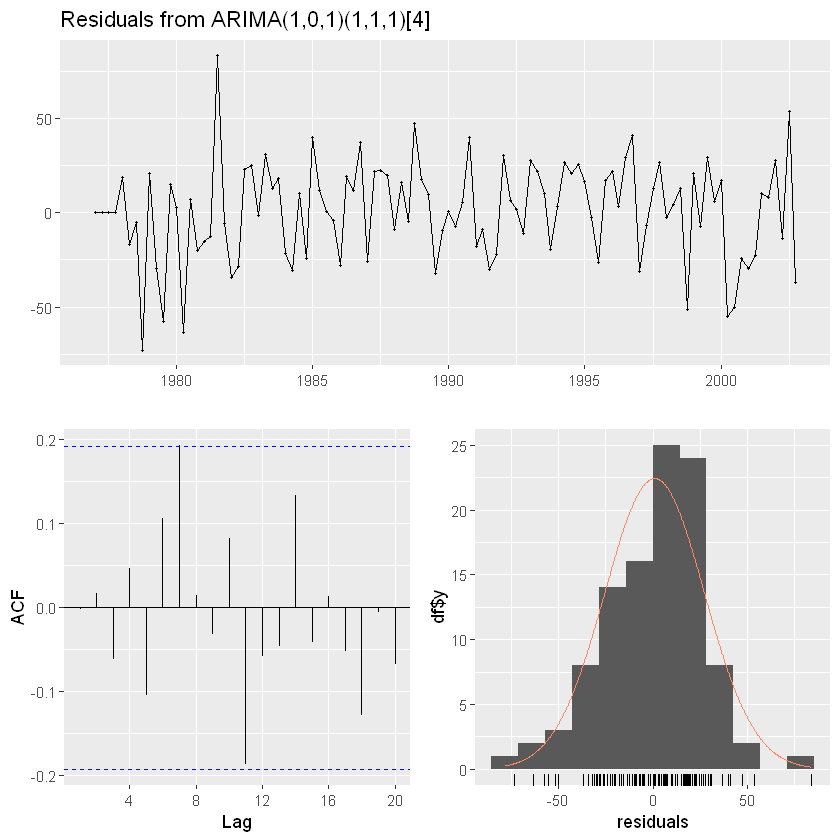

In [644]:
# 잔차검정
checkresiduals(model3)
t = 1:length(train)
bptest(lm(model3$residuals~t))

- 잔차가 등분산인지 검정하기 위해 Breusch-Pagan 검정을 실시하였더니 유의확률 0.6809로 유의수준 0.05 하에서 영가설($H_0$:등분산)을 기각할 수 없어 등분산이라고 판단한다.
-  Ljung-Box 검정 $H_0: \rho_1 = \rho_2 = \rho_3 = ... = \rho_k = 0$  $vs.$  $H_1: not H_0$
- Ljung-Box 검정의 결과로 유의확률이 0.1144이므로 유의수준 0.05하에서 영가설을 기각할 수 없어 잔차는 백색 잡음이다.
- ACF Plot에서 acf가 모든 시차에서 유의하지 않다.
- 잔차의 히스토그램을 보니 정규분포보다 오른쪽으로 치우친 경향이 있지만 정규성의 위배 정도가 크지 않은 것 같다.


In [646]:
sarima_pred = predict(model3,8)$pred
sarima_pred

,Qtr1,Qtr2,Qtr3,Qtr4
2003,420.9922,397.9714,345.0822,395.1067
2004,429.2142,397.9321,359.7610,390.6852


`마지막 2년 승용차 생산 대수 예측(계절형 ARIMA 모형)`: predict()를 사용하여 다음 8개 data 예측
|년도|1분기|2분기|3분기|4분기|
|:---:|:---:|:---:|:---:|:---:|
|2003|420.9922 |397.9714|345.0822|395.1067|
|2004|429.2142|397.9321|359.7610|390.6852|

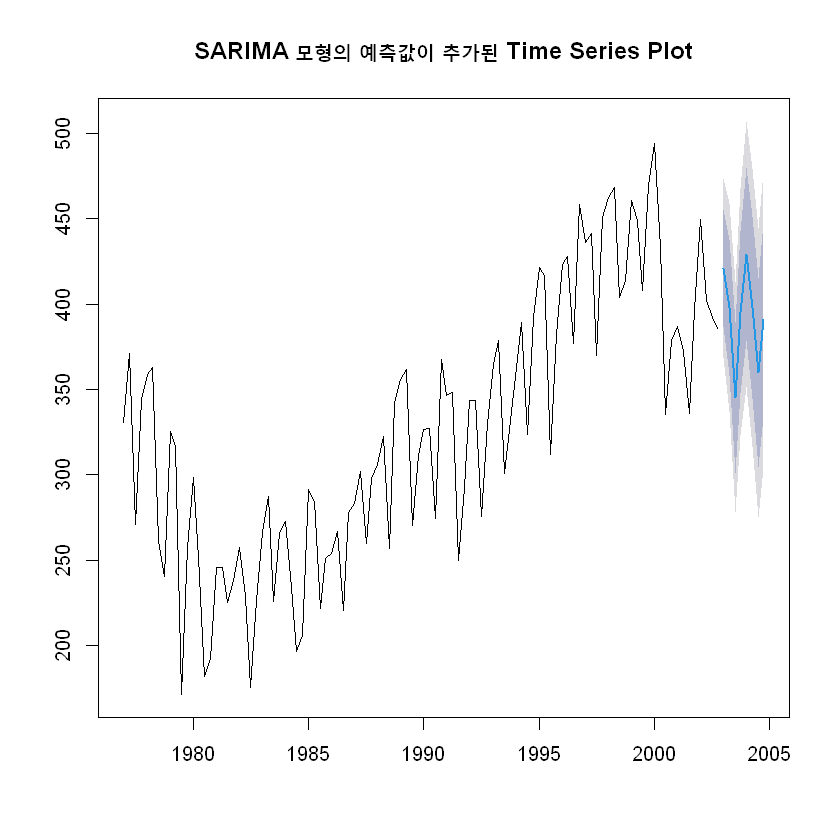

In [650]:
plot(forecast(model3, h=8,level = c(80, 95)) , main = "SARIMA 모형의 예측값이 추가된 Time Series Plot")

### 4-(7) 위 세 모형의 결과에 대하여 MSE/MAPE/MAE를 구하고, 가장 좋은 모형을 선택

In [651]:
## MSE, MAPE, MAE 구하는 함수
acc = function(true,pred){
     mse_ = sum((true-pred)^2)/8
     mape_ = sum(abs(true-pred)*100/true)/8
     mae_ = sum(abs(true-pred))/8
     return(paste(round(mse_,2) , round(mape_,2) , round(mae_,2)))
    }

In [658]:
# 단순이동평균 모형 accuracy
acc(ma_pred,test[1:8]) 

[1] "522.75 5.06 20.75"

In [655]:
# 중심이동평균 모형 accuracy
acc(cma_pred,test[1:8]) 

[1] "691.35 4.86 20.67"

In [656]:
# 가법 계절지수평활 accuracy
acc(expsmooting_pred,test[1:8])

[1] "1741.42 8.61 32.83"

In [657]:
# SARIMA accuracy
acc(sarima_pred , test[1:8])

[1] "2152.27 10.03 37.7"

`Accuracy`
|모형|MSE|MAPE|MAE|
|:---:|:---:|:---:|:---:|
|단순이동평균모형|522.75| 5.06| 20.75|
|중심이동평균모형|691.35 |4.86 |20.67|
|가법계절모형|1741.42|8.61|32.83|
|SARIMA|2152.27|10.03|32.83|

- MSE, MAPE, MAE 모두 가법계절 모형과 SARIMA 모형에 비해 이동평균 모형이 가장 작다.
- 이동평균모형 중 MSE가 단순이동평균 모형이 더 작다.  

=> 예측을 가장 잘 하고 좋은 모형은 단순이동평균 모형이다. 